#**Deep Learning Homework 5: *Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset seen in HW4.

In [ ]:
# import the usual libriaries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

np.random.seed(42)

### Load Dataset
We load the CIFAR-10 dataset, using `tf.keras.datasets`. The dataset contains 60,000 training images and 10,000 testing images.
The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between 0 and 255, and it represents a point of an image of size 32 x 32. We will normalize all values between 0 and 1, and we will flatten the 32x32 images into vectors of size 1024.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [ ]:
cifar_10 = keras.datasets.cifar10
(X_train_full, _), (x_test, _) = cifar_10.load_data() # The dataset is already divede in test and training

X_train_full, x_test = np.mean(X_train_full, -1), np.mean(x_test, -1)

X_train_full = X_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

X_train_full = X_train_full.reshape((len(X_train_full), np.prod(X_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# We extract the first 10000 samples of the training set, to use them as the validation set
x_valid, x_train = X_train_full[:10000], X_train_full[10000:]

170508288/170498071 [==============================] - 3s 0us/step


## [TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linealry combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices $V$ and $U$ and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in NumPy as `np.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the covariance matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [ ]:
def SVD(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k

Let's define the `ENCODING_DIM`, that will be the size of the compressed version of input data, and project the low-dimensional versions of the training set and the test set as well.

In [ ]:
ENCODING_DIM = 120

U_k = SVD(x_train, ENCODING_DIM)

x_training_svd = np.dot(x_train, U_k)
x_test_svd = np.dot(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [ ]:
x_training_reco = np.dot(x_training_svd, U_k.T)
x_test_reco = np.dot(x_test_svd, U_k.T)

In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00372
Test mse: 0.00375


In [ ]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

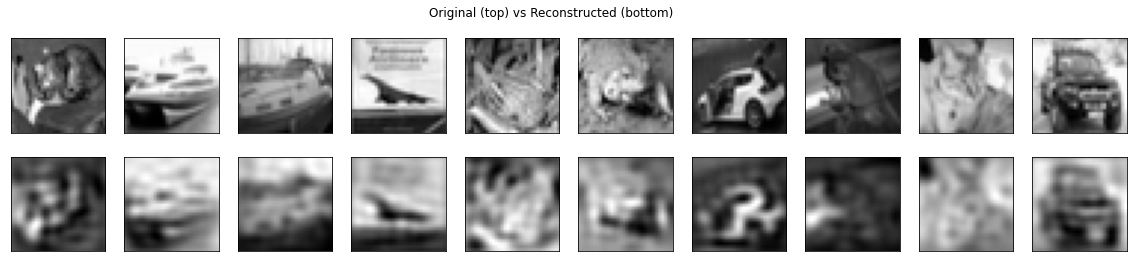

In [ ]:
plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

In [ ]:
x_train.shape

(40000, 1024)

In [ ]:
accuracy_trainm=[]
accuracy_testm=[]
for k in range(80,1000,20):
  ENCODING_DIM = k
  U_k = SVD(x_train, ENCODING_DIM)
  x_training_svd = np.dot(x_train, U_k)
  x_test_svd = np.dot(x_test, U_k)
  x_training_reco = np.dot(x_training_svd, U_k.T)
  x_test_reco = np.dot(x_test_svd, U_k.T)
  accuracy_trainm.append(((x_train - x_training_reco)**2).mean())
  accuracy_testm.append(((x_test - x_test_reco)**2).mean())

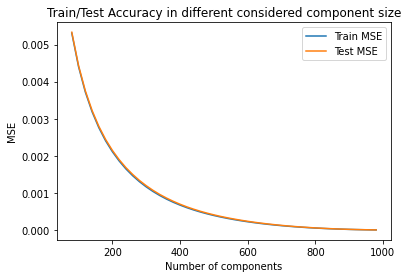

In [ ]:
import seaborn as sns
sns.lineplot(x=range(80,1000,20),y= accuracy_trainm)
sns.lineplot(x=range(80,1000,20),y= accuracy_testm)

plt.title("Train/Test Accuracy in different considered component size")
plt.xlabel("Number of components")
plt.ylabel("MSE");
plt.legend(['Train MSE', 'Test MSE'])

Training mse: 0.00349
Test mse: 0.00353


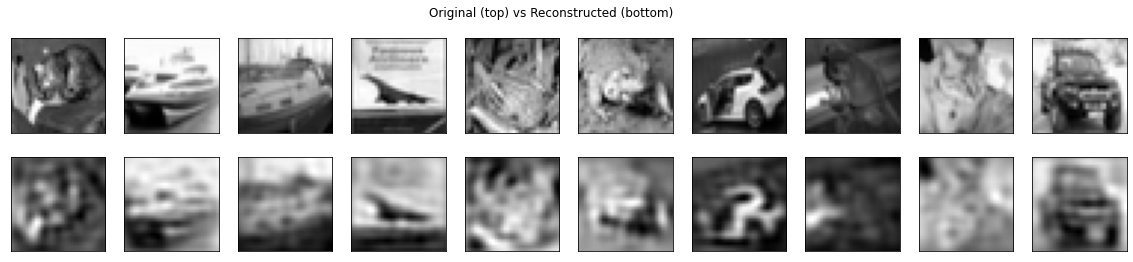

In [ ]:
ENCODING_DIM = 128

U_k = SVD(x_train, ENCODING_DIM)

x_training_svd = np.dot(x_train, U_k)
x_test_svd = np.dot(x_test, U_k)
x_training_reco = np.dot(x_training_svd, U_k.T)
x_test_reco = np.dot(x_test_svd, U_k.T)
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))
plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]**: What happens by varying the `ENCODING_DIM`? Try it out and discuss the results in this cell.

er
#####The `ENCODING_DIM` is number of dimensions that we want to consider in our simplified model. So when we increase this number, we see that the MSE reduces, which is sensible due to lower compression of the original images. The goal of using SVD here is to reduce the size of the vector of the image and preserve its salient feature, so it needs an experiment to find the right one. By evaluating MSE and output images in different numbers, we can decide which value for `ENCODING_DIM` is better for our problem. Instead of running just different values of `ENCODING_DIM`, we experimented with an array of different values and plotted the results of MSE. The plot clearly shows the behavior of the MSE with the size of the considered vector. When we are getting closer to the original size of the image, the MSE reduces, which is sensible, and vice versa.

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous HW when we used `Keras.Sequential()`, here we define the two parts of the model (encoder and decoder) separately and then we create the final model. 


In [ ]:
ENCODING_DIM = 128
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

Print the model summary.

In [ ]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_10 (Dense)            (None, 128)               131200    
                                                                 
 dense_11 (Dense)            (None, 1024)              132096    
                                                                 
Total params: 263,296
Trainable params: 263,296
Non-trainable params: 0
_________________________________________________________________


*Train* the model.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=25, batch_size=64, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/25
625/625 [==============================] - 4s 5ms/step - loss: 0.0206 - val_loss: 0.0097
Epoch 2/25
625/625 [==============================] - 3s 5ms/step - loss: 0.0079 - val_loss: 0.0066
Epoch 3/25
625/625 [==============================] - 3s 5ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 4/25
625/625 [==============================] - 3s 5ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 5/25
625/625 [==============================] - 3s 5ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 6/25
625/625 [==============================] - 3s 5ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 7/25
625/625 [==============================] - 3s 5ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 8/25
625/625 [==============================] - 3s 5ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 9/25
625/625 [==============================] - 3s 5ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 10/25
625/625 [==============================] - 3s 5ms/step - loss: 0.0040 - val_loss: 0.0040

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.grid()
  plt.title('loss')

313/313 - 0s - loss: 0.0038 - 456ms/epoch - 1ms/step
Test mse: 0.00384


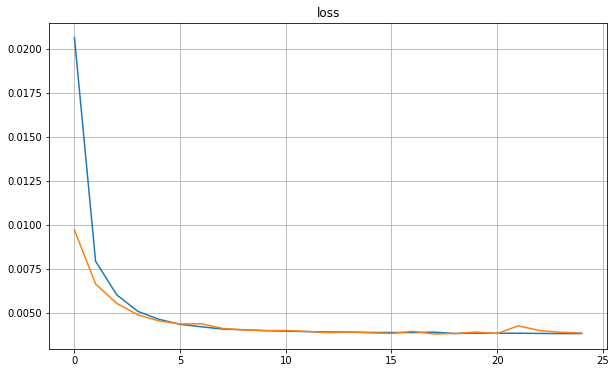

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

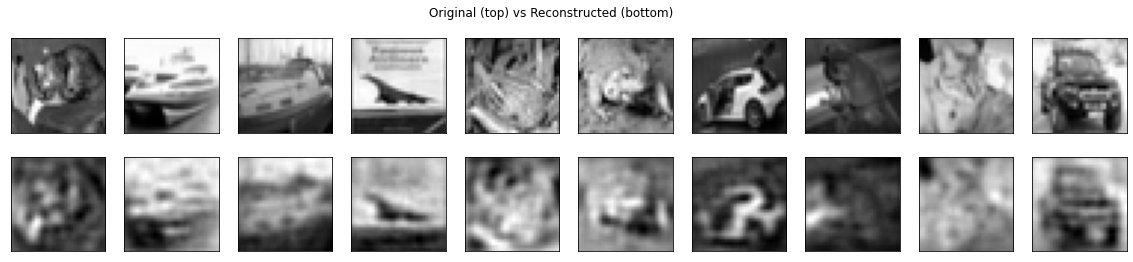

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]** Check the results and compare them versus the results obtained with the SVD. Give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.

<h2><mark><b>Answer <h2><mark><b>

#####If we consider only the MSE of the two methods, approximately the SVD and Linear Autoencoder have the same result. The first thing that comes to mind is that a linear autoencoder is just a linear transformation of the input. Furthermore, if we dive into the definition of the SVD, it can be understood that this method linearly generates the output of the reduced matrix. So it can be concluded that although they are different methods, they generate the output linearly from the input. The printed images also are the same images after the dimensionality reduction.

##[TO COMPLETE] Exercise 5.3: Shallow Non-linear Autoencoders

**[TO COMPLETE]** Replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. 

Insert your code and theoretical discussion into cells immediately below this one.


<h2><mark><b>Answer: <h2><mark><b>

#####There is three common choices for non-linear activation function here. As a first choice, we can choose the relu function for the neural network. The other options are sigmoid and tanh function. The relu is nonlinear but if you consider the positive part of the function, it is linear. Furthermore, our data are positive, so there isnt too much different between the linear and relu here.in addition, there difference between tanh and sigmoid is that the sigmoid is between 0 and 1 but the tanh is between -1 and 1( I mean the overal behavior is the same). One of the major problems of sigmoid or tanh function is the gradient in the backpropagation will vanish for values very positive or negative since we normalized our data at the beginning, so we are not dealing with kind of problem in our case. Furthermore, our values are between 0 and 1, and we don't need to use the tanh function. By considering all the facts which is not enough for choosing an activation function and we need a experiment to choose them, we evaluated the model's performance for three different activation functions, and the results of sigmoid function were better than two others activation functions.

#####After enough number of epoch by looking at the accuracy and loss plots, the results of MSE in the shallow non-linear autoencoder is a little bit worser than linear autoencoder. But when we compare the output images, it can be seen that the output images for non-linear autoencoder are less blurred.

In [ ]:
ENCODING_DIM = 128
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

Print the model summary.

In [ ]:
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_12 (Dense)            (None, 128)               131200    
                                                                 
 dense_13 (Dense)            (None, 1024)              132096    
                                                                 
Total params: 263,296
Trainable params: 263,296
Non-trainable params: 0
_________________________________________________________________


*Train* the model.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=32, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/50
1250/1250 [==============================] - 6s 4ms/step - loss: 0.0213 - val_loss: 0.0144
Epoch 2/50
1250/1250 [==============================] - 6s 4ms/step - loss: 0.0116 - val_loss: 0.0102
Epoch 3/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0093 - val_loss: 0.0086
Epoch 4/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 5/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 6/50
1250/1250 [==============================] - 6s 4ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 7/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 8/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 9/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 10/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.005

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.

313/313 - 0s - loss: 0.0045 - 476ms/epoch - 2ms/step
Test mse: 0.00452


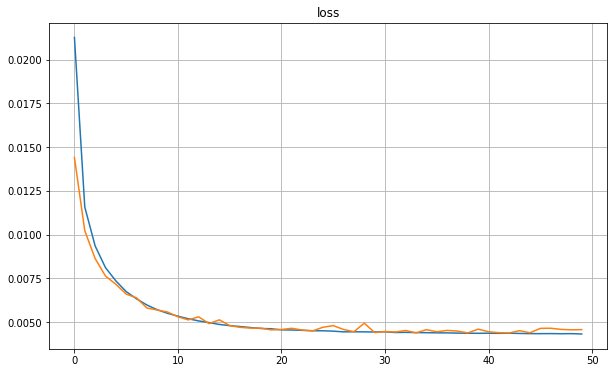

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

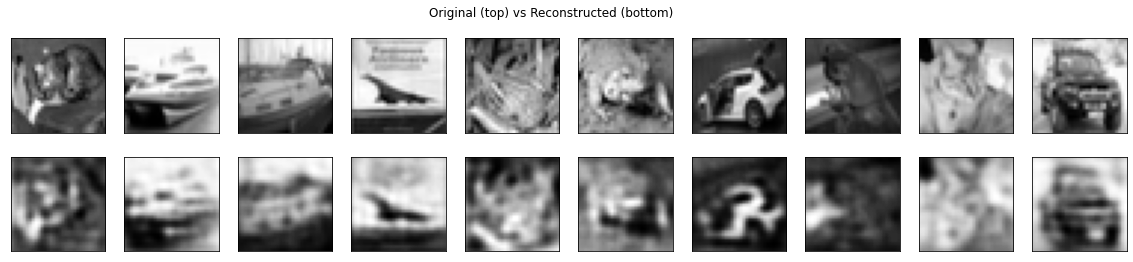

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]** Build a deep version of the Autoencoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g., `INPUT_DIM->128->64`, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (e.g., `128->INPUT_DIM`, the final overall structure recalls an hourglass ⏳).
As usual, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [ ]:
ENCODING_DIM = 128
HIDDEN_DIM=256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(HIDDEN_DIM, activation='sigmoid')(input_img)
encoded_H = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(encoded)
# ...the decoder...
decoded_H = tf.keras.layers.Dense(HIDDEN_DIM, activation='relu')(encoded_H)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(decoded_H)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_48 (Dense)            (None, 256)               262400    
                                                                 
 dense_49 (Dense)            (None, 128)               32896     
                                                                 
 dense_50 (Dense)            (None, 256)               33024     
                                                                 
 dense_51 (Dense)            (None, 1024)              263168    
                                                                 
Total params: 591,488
Trainable params: 591,488
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(x_train, x_train, epochs= 50, batch_size= 32 , shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/50
1250/1250 [==============================] - 14s 11ms/step - loss: 0.0244 - val_loss: 0.0191
Epoch 2/50
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0167 - val_loss: 0.0152
Epoch 3/50
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0145 - val_loss: 0.0140
Epoch 4/50
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0130 - val_loss: 0.0124
Epoch 5/50
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0119 - val_loss: 0.0115
Epoch 6/50
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 7/50
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0106 - val_loss: 0.0102
Epoch 8/50
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0101 - val_loss: 0.0100
Epoch 9/50
1250/1250 [==============================] - 11s 8ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 10/50
1250/1250 [==============================] - 10s 8ms/step - 

313/313 - 1s - loss: 0.0058 - 766ms/epoch - 2ms/step
test mse: 0.00583


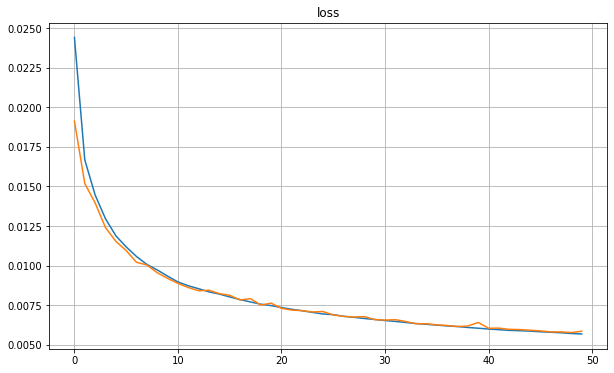

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

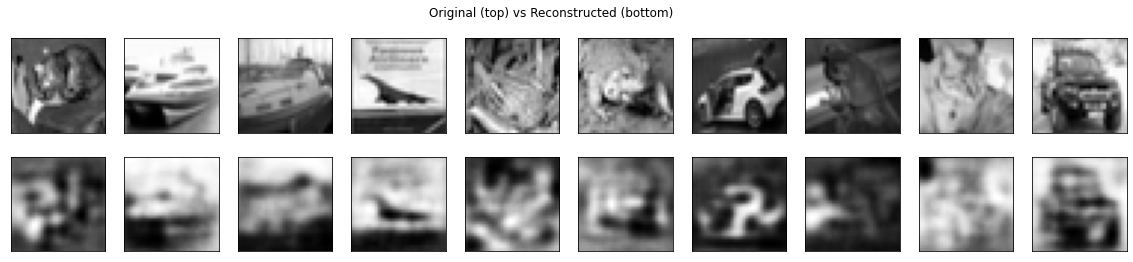

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data. The idea is that only meaningful information will be encoded, thus filtering out useless noise.
Firstly, define a noisy input by adding some gaussian noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

<h2><mark><b>Answer: <h2><mark><b>

##### With noise factor equal to 0.4 the MSE is 0.01339 and for noise factor equal to 0.3 the MSE is 0.0107. Also the output images of less noisy inputs are better in the output.

In [ ]:
noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

# we still have to be sure that the color values are in the [0,1] range:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs:

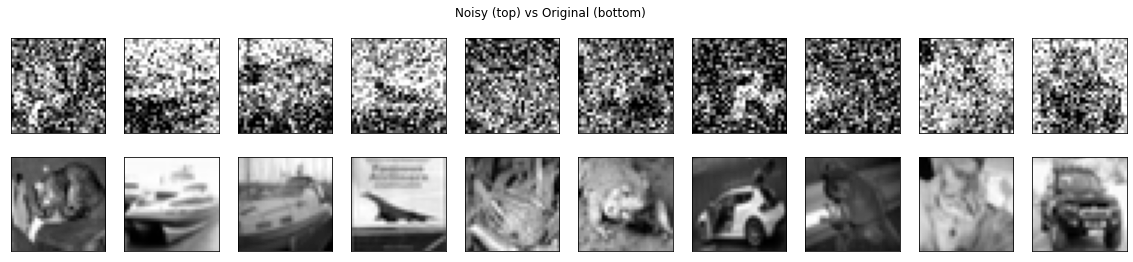

In [ ]:
plot_img(10, [x_test_noisy, x_test], title = "Noisy (top) vs Original (bottom)")

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (use a noise_factor $\geq 0.3$). 

In [ ]:
INPUT_DIM = x_train.shape[-1]
ENCODING_DIM = 256


input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
#[TO COMPLETE]
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)

autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse') #[TO COMPLETE]

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train, epochs= 25, batch_size= 32 , shuffle=True, validation_data=(x_valid_noisy, x_valid)) #[TO COMPLETE]

Epoch 1/25
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0210 - val_loss: 0.0145
Epoch 2/25
1250/1250 [==============================] - 11s 8ms/step - loss: 0.0134 - val_loss: 0.0128
Epoch 3/25
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0121 - val_loss: 0.0131
Epoch 4/25
1250/1250 [==============================] - 11s 9ms/step - loss: 0.0116 - val_loss: 0.0122
Epoch 5/25
1250/1250 [==============================] - 9s 7ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 6/25
1250/1250 [==============================] - 9s 7ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 7/25
1250/1250 [==============================] - 9s 7ms/step - loss: 0.0108 - val_loss: 0.0111
Epoch 8/25
1250/1250 [==============================] - 9s 7ms/step - loss: 0.0107 - val_loss: 0.0109
Epoch 9/25
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0106 - val_loss: 0.0109
Epoch 10/25
1250/1250 [==============================] - 10s 8ms/step - loss:

313/313 - 1s - loss: 0.0107 - 877ms/epoch - 3ms/step
Test mse: 0.01071


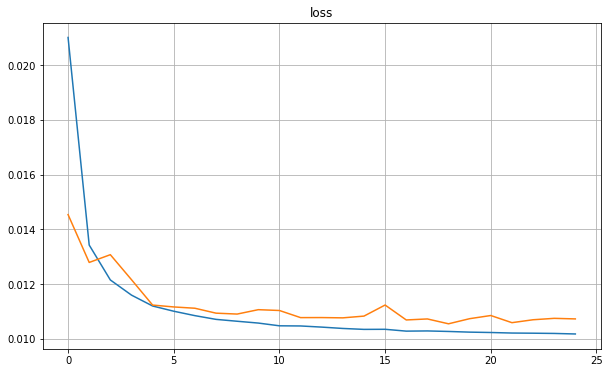

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

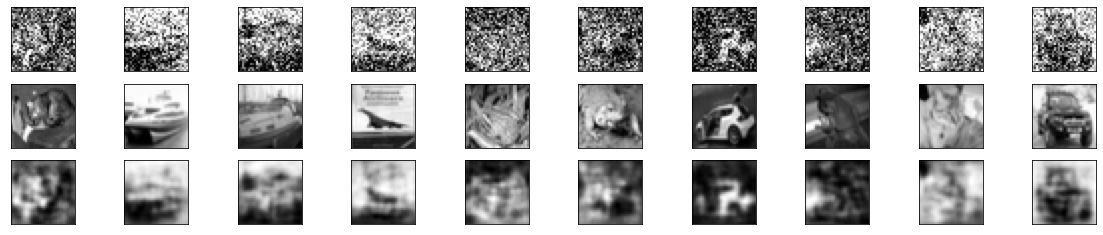

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, [x_test_noisy, x_test, decoded_imgs])

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case we will use the IMDB dataset (already introduced in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in _Colab_), we will limit the number of training samples and test samples.

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

1654784/1641221 [==============================] - 0s 0us/step


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [ ]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using `tf.keras.layers.SimpleRNN`. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 90, 50)            7550      
                                                                 
 time_distributed (TimeDistr  (None, 90, 100)          5100      
 ibuted)                                                         
                                                                 
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 9s 91ms/step - loss: 0.2292 - categorical_accuracy: 0.0470 - val_loss: 0.1128 - val_categorical_accuracy: 0.1313
Epoch 2/50
79/79 [==============================] - 7s 87ms/step - loss: 0.0904 - categorical_accuracy: 0.2875 - val_loss: 0.0766 - val_categorical_accuracy: 0.4073
Epoch 3/50
79/79 [==============================] - 7s 89ms/step - loss: 0.0669 - categorical_accuracy: 0.4700 - val_loss: 0.0605 - val_categorical_accuracy: 0.4983
Epoch 4/50
79/79 [==============================] - 7s 91ms/step - loss: 0.0547 - categorical_accuracy: 0.5244 - val_loss: 0.0515 - val_categorical_accuracy: 0.5355
Epoch 5/50
79/79 [==============================] - 7s 88ms/step - loss: 0.0475 - categorical_accuracy: 0.5498 - val_loss: 0.0478 - val_categorical_accuracy: 0.5534
Epoch 6/50
79/79 [==============================] - 7s 88ms/step - loss: 0.0435 - categorical_accuracy: 0.5775 - val_loss: 0.0414 - val_categorical_accuracy: 0.5888
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 1s - loss: 0.0096 - categorical_accuracy: 0.9483 - 517ms/epoch - 13ms/step
categorical_accuracy: 94.83%


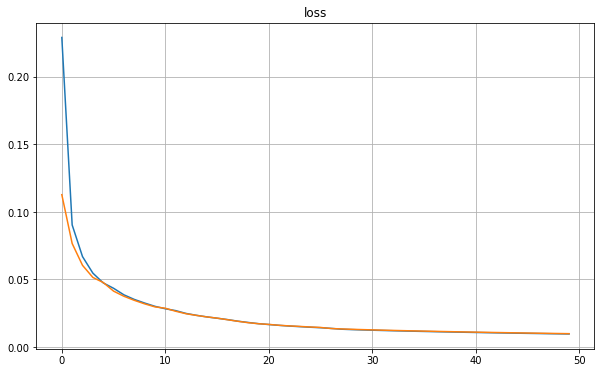

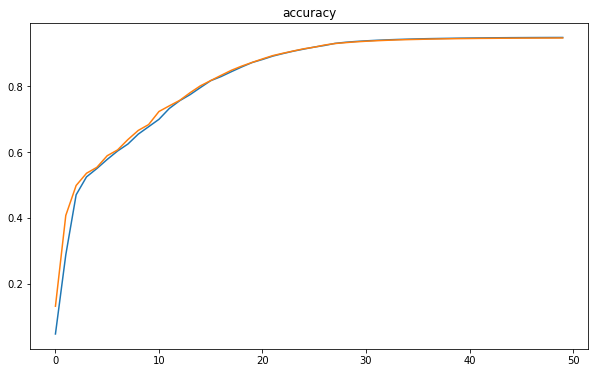

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that made but that <oov> the <oov> is <oov> a with <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a good to film that <oov> <oov> <oov> than a <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> with <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

<h2><mark><b>Answer: <h2><mark><b>

#####The results on the test set show us a better performance of this model compared to the non-linear activation function. We discussed before the advantages and disadvantages of the non-linear functions. It has been mentioned that it needs to consider different activation functions for a problem and evaluate its performance to choose the correct one. Hereafter considering different activation functions, the results showed that the sigmoid function had better performance than other functions. In addition, the output is a one-hot vector, and we considered the binary cross-entropy for it so that the softmax can be a good choice for output layer activation. The 100% accuracy of test results at the end also confirms the right choice for choosing the softmax function. 

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='sigmoid')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 lstm (LSTM)                 (None, 90, 50)            30200     
                                                                 
 time_distributed_2 (TimeDis  (None, 90, 100)          5100      
 tributed)                                                       
                                                                 
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 14s 155ms/step - loss: 0.0432 - categorical_accuracy: 0.4048 - val_loss: 0.0371 - val_categorical_accuracy: 0.4614
Epoch 2/50
79/79 [==============================] - 12s 154ms/step - loss: 0.0363 - categorical_accuracy: 0.4710 - val_loss: 0.0362 - val_categorical_accuracy: 0.4614
Epoch 3/50
79/79 [==============================] - 12s 152ms/step - loss: 0.0349 - categorical_accuracy: 0.4710 - val_loss: 0.0342 - val_categorical_accuracy: 0.4614
Epoch 4/50
79/79 [==============================] - 12s 148ms/step - loss: 0.0321 - categorical_accuracy: 0.4710 - val_loss: 0.0307 - val_categorical_accuracy: 0.4614
Epoch 5/50
79/79 [==============================] - 12s 147ms/step - loss: 0.0281 - categorical_accuracy: 0.4710 - val_loss: 0.0262 - val_categorical_accuracy: 0.4620
Epoch 6/50
79/79 [==============================] - 12s 154ms/step - loss: 0.0234 - categorical_accuracy: 0.5898 - val_loss: 0.0213 - val_categorical_accuracy: 0.707

40/40 - 1s - loss: 3.3855e-05 - categorical_accuracy: 1.0000 - 875ms/epoch - 22ms/step
categorical_accuracy: 100.00%


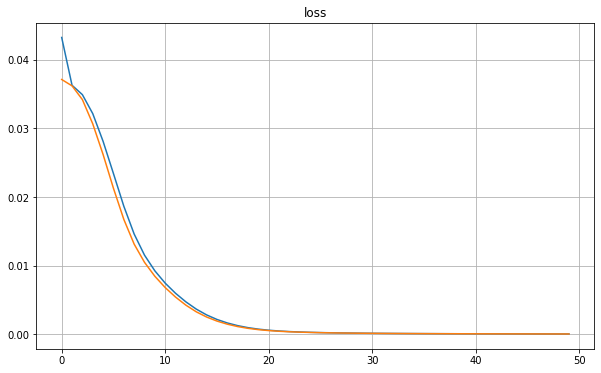

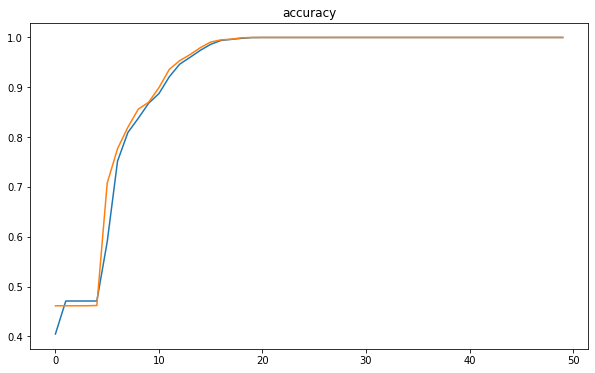

In [ ]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
